# Process Cap Quotes

This notebook 
* converts Bloomberg cap quotes into Black flat vols.
* interpolates the vol curve
* interpolates the SOFR swap curve from BB quotes.
* calculates swap, discount, and forward curves

User picks a date, and among the historic dates loaded, it builds the curves for this particular date.

Pair this notebook with `build_data/Build Cap Quotes - Bloomberg`.

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ratecurves import *
from ficcvol import *
from treasury_cmds import compound_rate
from bondmath import bootstrap_discounts_clean

from datetime import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

***

In [3]:
FILEDATE = '2024-03-05'
FILEIN = f'../data/cap_quotes_{FILEDATE}'
BB_COMPOUND = 1 #compounding of quoted SOFR swaps
freqcap = 4
# can adjust frequency for binomial tree later, but keep quarterly to properly get caps

### Select Date for Analysis

In [4]:
DATE = '2024-03-05'

### Export Curves to Excel

In [5]:
SAVEDATA = True
FILEOUT = f'../data/cap_curves_{DATE}.xlsx'

# SOFR Quotes

In [6]:
SHEET = 'sofr'
sofrdata_raw = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
sofrdata_raw.columns = sofrdata_raw.loc['maturity'] 
sofrdata_raw.drop(index=['maturity'],inplace=True)
sofrdata_raw.index = pd.to_datetime(sofrdata_raw.index)

sofrdata_raw.columns.name ='maturity'

Bloomberg reports rates as percentages; convert to numbers.

In [7]:
sofrdata_raw /= 100

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [8]:
sofrdata_raw = sofrdata_raw.T.drop_duplicates().T

## Get Curves

Need discount and forward curves.

Need to interpolate swap rates for quarterly frequency beyond $T=3$ (which is where Bloomberg moves from monthly to semiannual tenors.)

Many reasonable methods, try `cubicspline`.

### Compounding

Bloomberg is quoting the swap rates per the swap frequency.

SOFR swaps are listed as annual frequency.

For convenience of our `freqcap` grid, convert this compounding.

In [9]:
sofrdata = sofrdata_raw.copy()
sofrdata = compound_rate(sofrdata,BB_COMPOUND,freqcap)
sofrdata.tail().style.format('{:.2%}').format_index('{:%Y-%m-%d}',axis=0).format_index('{:.2f}',axis=1)

maturity,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.50,4.00,4.50,5.00,6.00,7.00,8.00,9.00,10.00
date,,,,,,,,,,,,,,,,,,,,,
2024-02-28,5.23%,5.17%,5.08%,4.97%,4.81%,4.67%,4.56%,4.46%,4.37%,4.29%,4.23%,4.19%,4.09%,4.04%,3.98%,3.95%,3.90%,3.86%,3.85%,3.83%,3.83%
2024-02-29,5.23%,5.16%,5.07%,4.95%,4.79%,4.65%,4.54%,4.45%,4.35%,4.27%,4.22%,4.17%,4.08%,4.02%,3.97%,3.94%,3.89%,3.86%,3.84%,3.82%,3.82%
2024-03-01,5.22%,5.13%,5.03%,4.91%,4.74%,4.59%,4.47%,4.38%,4.28%,4.20%,4.14%,4.10%,4.00%,3.95%,3.89%,3.86%,3.82%,3.79%,3.77%,3.76%,3.75%
2024-03-04,5.23%,5.16%,5.07%,4.95%,4.79%,4.65%,4.53%,4.44%,4.34%,4.26%,4.20%,4.15%,4.06%,4.00%,3.94%,3.91%,3.85%,3.82%,3.80%,3.79%,3.78%
2024-03-05,5.22%,5.15%,5.04%,4.92%,4.75%,4.61%,4.49%,4.39%,4.29%,4.21%,4.15%,4.10%,4.00%,3.94%,3.88%,3.85%,3.79%,3.76%,3.74%,3.73%,3.72%


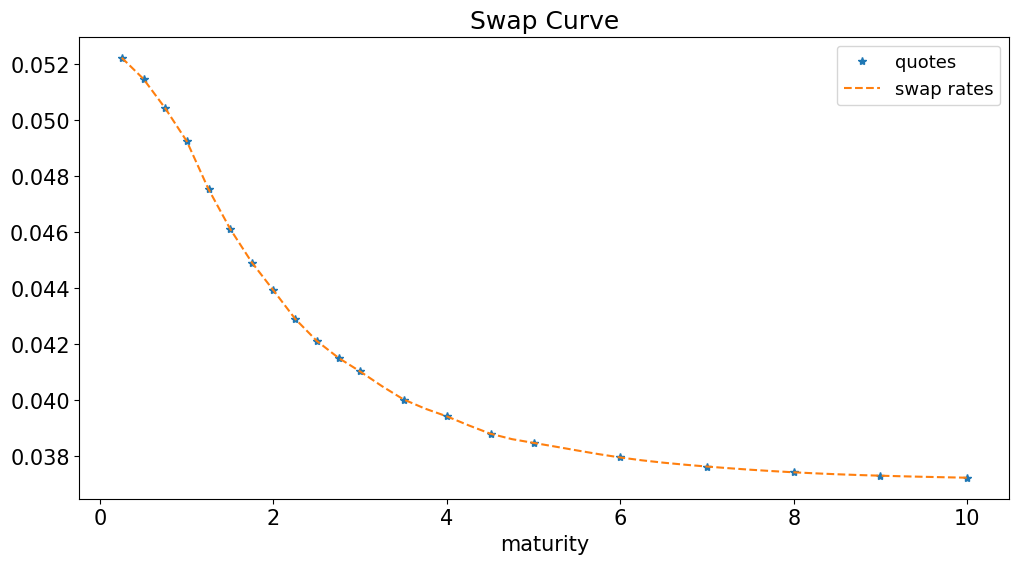

In [10]:
sofrcurves = interp_curves(sofrdata, dt = 1/freqcap, date=DATE, interp_method='cubicspline').rename(columns={'interp':'swap rates'})
sofrquotes = sofrdata.loc[DATE,:].rename('quotes')

### Plot the Curve
fig, ax = plt.subplots()
sofrquotes.plot.line(ax=ax, linestyle='None',marker='*')
sofrcurves['swap rates'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Swap Curve');

In [11]:
sofrcurves['spot rates'] = bootstrap_discounts_clean(sofrcurves[['swap rates']],compounding=freqcap,key='swap rates')

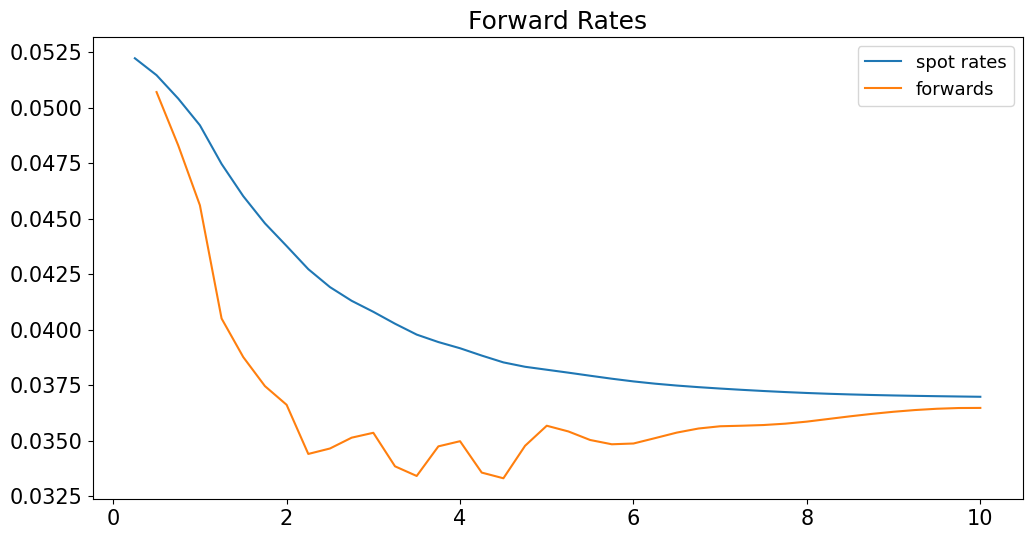

In [12]:
sofrcurves['discounts'] = ratecurve_to_discountcurve(sofrcurves['spot rates'],n_compound=freqcap)
sofrcurves['forwards'] = ratecurve_to_forwardcurve(sofrcurves['spot rates'],n_compound=freqcap)
sofrcurves[['spot rates','forwards']].plot(title='Forward Rates');

In [13]:
sofrcurves

,quotes,swap rates,spot rates,discounts,forwards
0.25,NaN,0.052226,0.052226,0.987112,NaN
0.50,NaN,0.051470,0.051465,0.974756,0.050705
0.75,NaN,0.050427,0.050411,0.963125,0.048303
1.00,NaN,0.049243,0.049209,0.952268,0.045606
1.25,NaN,0.047534,0.047467,0.942722,0.040506
1.50,NaN,0.046112,0.046016,0.933672,0.038769
1.75,NaN,0.044914,0.044793,0.925009,0.037462
2.00,NaN,0.043913,0.043770,0.916617,0.036620
2.25,NaN,0.042897,0.042729,0.908800,0.034407
2.50,NaN,0.042107,0.041920,0.900995,0.034653


# Cap Quotes

In [14]:
SHEET = 'cap'
capdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
capdata.columns = capdata.loc['maturity'] 
capdata.drop(index=['maturity'],inplace=True)
capdata.index = pd.to_datetime(capdata.index)

Bloomberg reported years-to-maturity are precise.
Round these to nearest $dt$ for better column headers
For more precise work, would need to make use of the precise maturities, but for this purpose will make no difference.

In [15]:
capdata.columns = (freqcap * capdata.columns.values).round(0)/freqcap
capdata.columns.name ='maturity'

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [16]:
capdata = capdata.T.drop_duplicates().T

## Adjusting Normal Vol to Lognormal (Black) Vol

Cap quotes in Bloomberg are downloaded in
* normal vol
* terminal allows view of lognormal (Black) vol, but API seemingly restricts to normal.

The normal vols are reported in basis points.
* divide out by $100^2$

Converting between normal and lognormal vol is given by a simple formula for ATM options, (according to SABR, etc.)

$$\sigma_B = \frac{\sigma_N}{f}$$

where $f$ is the forward rate.

In [17]:
capquotes = capdata.loc[DATE,:].to_frame()
capquotes.columns = ['normal']
capquotes[DATE] = capquotes['normal'] / sofrcurves['forwards'] / 100**2

# Interpolate or Extrapolate

Interpolate/extrapolate just to get to quarterly frequency needed for forward vol extraction.

After extracting forward vol, can interpolate/extrapolate further for matching timegrid of binomial trees.

#### Interpolation
Need to interpolate cap rates for quarterly frequency as Bloomberg reports only at annual tenors.

Try `cubicspline`.

#### Extrapolation
Also need to extrapolate the short end of the curve, $t<1$.
* This can lead to negative values w/ cubic spline and others.
* Here, ad hoc set front to `FRONT_RATIO` the first quote and linearly extrapolate

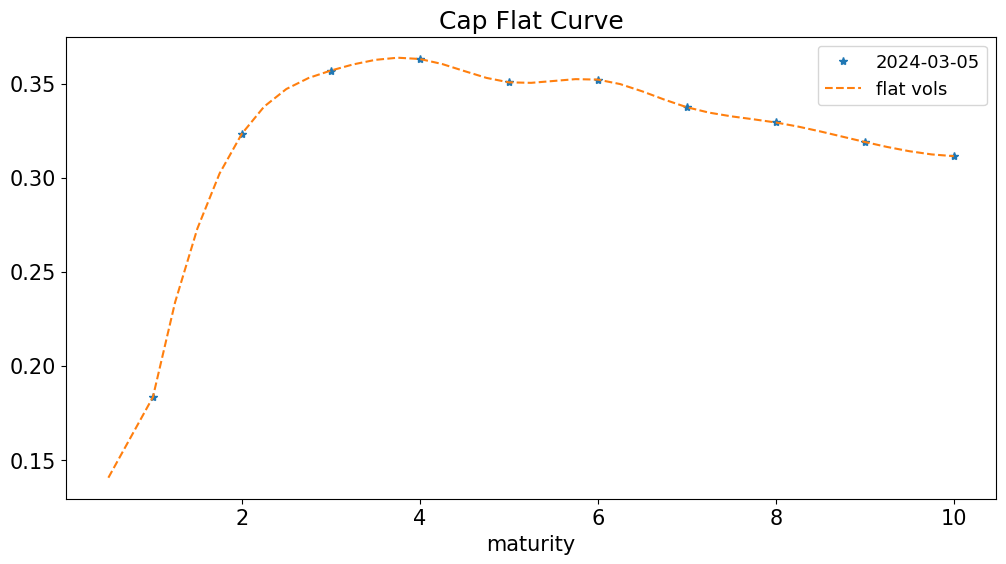

In [18]:
LIN_EXTRAP = True
FRONT_RATIO = .65

capcurves = interp_curves(capquotes[[DATE]].T,dt=1/freqcap, date=DATE,interp_method='cubicspline').rename(columns={'interp':'flat vols'})

if LIN_EXTRAP:
    fix_short = capcurves.loc[:1,'flat vols']
    fix_short.iloc[:-1] = np.nan
    fix_short.iloc[0] = capcurves.loc[1,'flat vols'] * FRONT_RATIO
    capcurves.loc[:1,'flat vols'] = fix_short.interpolate(limit_direction='both', fill_value = 'extrapolate')

# drop extrapolated value at first period as there is no caplet for the first period.
capcurves['flat vols'].iloc[0] = np.nan

### Plot the Curve
fig, ax = plt.subplots()
capquotes[[DATE]].rename(columns={'black':'quotes'}).plot.line(ax=ax, linestyle='None',marker='*')
capcurves['flat vols'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Cap Flat Curve');

In [19]:
capcurves = flat_to_forward_vol_rev(capcurves['flat vols'],sofrcurves['swap rates'],sofrcurves['forwards'],sofrcurves['discounts'],freq=4)

### Save Data

In [20]:
outdata = pd.concat([sofrcurves.drop(columns=['quotes']), capcurves.drop(columns=['cap prices'])],axis=1)
outdata.index.name = 'tenor'

if SAVEDATA:    
    with pd.ExcelWriter(FILEOUT) as writer:  
        outdata.to_excel(writer, sheet_name= f'rate curves {DATE}', index=True)